The code below scrapes data(Bond futures) from a public ASX website and feeds a specific part of the data into a GRU model. GRU stands for Gated Recurrent Unit and(in a way)is a more simplified variant of the LSTM which is a Long Short Term Memory Neural Network model.

The preference is to use these models for natural language processing but it is always of interest to see how a model might behave on new data.

The code below is part of a larger function that scrapes financial markets data from public websites
and stores the data in a dataframe for use later and ongoing feeding to machine learning algorithms.


#### Related articles
Gated Recurrent Unit(GRU) - Cho et al. 2014. https://arxiv.org/pdf/1406.1078.pdf

GRU's:test on polyphonic music modelling and speech signal modelling.https://arxiv.org/abs/1412.3555

#### Nov/2018

In [11]:
#ASX 3yr Australian Government bond futures("yt") futures scrape, using requests and beautiful soup.   
#Scrape responsibly!

#Randoms
import sys
import sched
 
#Numpy 
import numpy as np
from numpy import zeros
 
#Scrape dependencies,soup and requests
import requests
import bs4
from bs4 import BeautifulSoup
from dateutil.parser import parse

#Time, datetime
import time
from datetime import datetime as dt
import datetime

#Pandas
import pandas as pd 
from pandas import Series
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
 
#Tensorflow backend
import tensorflow 
import keras
from keras.models import Sequential
from keras import losses
from numpy import array
from keras.layers import Dense
import keras.backend as K
from keras import regularizers
from keras import optimizers
from keras.layers import Dropout, Input
from keras.layers import LSTM,GRU
 
#SK learn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
 
#Plot
import matplotlib.pyplot as plt
from textblob import TextBlob, Word
%matplotlib inline


 
#Functions 
#Define current time for while loop
def now_str():
    """Return hh:mm string representation of the current time."""
    t = dt.now().time()
    return t.strftime("%H:%M")

#Plot function
def auto_plot(self): 
    autocorrelation_plot(self)
    plt.show()
        
#Differencing function    
def  difference_data(self): 
    X_diff=Series(np.diff(self,axis=0))
    return X_diff

#Lag data by one period(day)
def shift_values(self):
    values = DataFrame(self.values)
    dataframe_1 = concat([values.shift(1),values], axis=1)
    dataframe_1.columns = ['change(t-1)','change(t)']
    X_shift= dataframe_1.dropna(inplace=False)
    return X_shift 

#Split data into train/test(90/10)
def split_data(self):
    size = int(len(self) * 0.8)
    train, test = self[0:size], self[size:len(self)]
    return train,test

#Scale data to -1/1 range. Using GRU default tanh activation function. 
def scale_data(train,test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_s = scaler.transform(train)
    test_s = scaler.transform(test)
    return train_s,test_s        
        
#GRU model 
def fit_gru_stateless(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons): 
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1]) 
    model_gru = Sequential()
    model_gru.add(GRU(n_neurons,input_shape=(1,1)))       
    model_gru.add(Dense(y.shape[1]))
    model_gru.compile(loss='mean_squared_error', optimizer='adam')   
    history = model_gru.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=0, shuffle=False)                
    return model_gru
     
#Store predictions from GRU model
def forecast_gru_stateless(model, X, n_batch):  
    X = X.reshape(1, 1, len(X))    
    forecast = model.predict(X, batch_size=n_batch)    
    return [x for x in forecast[0, :]]

#Run predictions on test data 
def make_forecasts_stateless(model, n_batch, train, test, n_lag, n_seq):
    forecasts_s = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]        
        forecast = forecast_gru_stateless(model, X, n_batch)      
        forecasts_s.append(forecast)
    return forecasts_s

#Print error of GRU model
def evaluate_forecasts_stateless(test, forecasts_s, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts_s]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        print('RMSE: %f' % ( rmse))         
        
#Run model on non-differenced data 
def run_model(self):    
    auto_plot(self)     
    print"RMSE without differencing"
    X_shift = shift_values(self)
    train,test= split_data(X_shift)
    train_s,test_s = scale_data(train,test)    
    model_gru= fit_gru_stateless(train_s, 1, 1, 1,5, 3)    
    forecasts_s= make_forecasts_stateless(model_gru, 1, train_s, test_s, 1, 1)     
    evaluate_forecasts_stateless(test_s, forecasts_s, 1, 1)
        
#Run model on differenced data
def run_model_diff(self):    
    print "RMSE with differencing"
    X_diff= difference_data(self)
    X_shift = shift_values(X_diff)     
    train,test= split_data(X_shift)
    train_s,test_s = scale_data(train,test)               
    model_gru = fit_gru_stateless(train_s, 1, 1, 1,5, 3)     
    forecasts_s = make_forecasts_stateless(model_gru, 1, train_s, test_s, 1, 1)     
    evaluate_forecasts_stateless(test_s, forecasts_s, 1, 1)           
    
#Shut down any unwanted deprecation warnings    
pd.options.mode.chained_assignment = None     

In [2]:
#Read in full dataset from larger scrape
 yt_bucket = pd.read_csv('...asx_yt..',index_col='scraped_time')

In [3]:
#Scrape responsibly!

#This loop scrapes 3yr Australian Government bond futures prices from a public website.
 
starttime=time.time()
bucket_yt=[] 
t_1=[]
i = 0
while True:
    t = dt.now().time()
    t_1.append(t)
    print'scraped at',dt.now().time()
    url = "https://www.....asx....com....."
    html = requests.get(url)
    soup = BeautifulSoup(html.text, 'html.parser')
    asxrows = soup.find_all('tr', {'class': 'row-alt'})    
    for eachRow in asxrows:        
        if eachRow.findChildren()[0].text.find('YT') == 0:            
            for itm in eachRow.find_all('td'):
                bucket_yt.append(itm.text.strip())
    i = i + 1
    
#Bot sleeps for 450 seconds and scrapes again until it is instructed to stop.
#This example scrapes 4 times every 450 seconds and then feeds data into existing dataset
#which is then passed to the GRU model for analysis.
    time.sleep(450.0 - ((time.time() - starttime) % 450.0))    
    if i == 4:
        print "exiting while loop"
        break 
        
        
#Prep scraped data to append to existing data set        
bucket_yt = np.array(bucket_yt)
big_yt = bucket_yt.reshape(4,11) 
yt = pd.DataFrame(columns=[ 'expiry', 'bid', 'ask', 'open', 'high','low', 'Last_Trade','Last_Trade_Time','Change',
                             'Traded_Volume','Previous_Settlement'],data=big_yt,index=t_1) 
yt.index.name='scraped_time'

#Save new data from this scrape to existing database
yt.to_csv('...asx_yt..')

scraped at 18:41:56.437319
scraped at 18:49:26.447495
scraped at 18:56:56.452499
scraped at 19:04:26.443002
exiting while loop


In [13]:
#Read in full dataset,strip out last trade price and corresponding time 
app_1=pd.read_csv('...asx_yt..')
app_2 = app_1[['Last_Trade_Time','Last_Trade']]
dates= app_2['Last_Trade_Time'] 
app_2['dates'] = [dt.strptime(x,'%d/%m/%Y %H:%M') for x in dates]
app_2.index=app_2['dates']
app_2.drop(columns=['Last_Trade_Time','dates'],inplace=True)
print "Dataset shape",app_2.shape
print""
print ""
print "First five rows of dataset" 
app_2.head()

Dataset shape (2621, 1)


First five rows of dataset


,Last_Trade
dates,
2018-05-03 18:06:00,97.7575
2018-05-03 18:06:00,97.7575
2018-05-03 18:14:00,97.7575
2018-05-03 19:12:00,97.7725
2018-05-03 20:13:00,97.7825


### Extract trades that occured in after market trading during London trading hours (5pm AET and 2am  AET)  

In [8]:
app_2.set_index= app_2.index.indexer_between_time('17:00','2:00')
x=np.array(app_2.between_time('17:00','2:00'))
#check shape of extracted data and assign to series for models.  
x.shape=(975,)
X=pd.Series(x)  

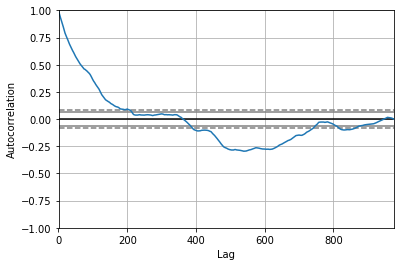

RMSE without differencing
RMSE: 0.018330
RMSE with differencing
RMSE: 0.097899


In [12]:
#Plot degree of autocorrelation in data and check root mean squared error versus(RMSE) 
#a baseline simple persistence model.

#RMSE persistence(no differencing): 0.071355. 
#RMSE persistence(differencing): 0.14  
#Y mean with differencing: 0.087874
#Y mean without differencing: 0.287570
run_model(X)
run_model_diff(X)